<a href="https://colab.research.google.com/github/AmbiTyga/Bio-VI-BERT/blob/main/One_shot_Pre_trained_Image_Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Mount Google Drive
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"

Mounted at /content/gdrive


In [2]:
#@title EarlyStopping
class EarlyStopping(object):
    def __init__(self, mode='min', min_delta=0, patience=10, percentage=False):
        self.mode = mode
        self.min_delta = min_delta
        self.patience = patience
        self.best = None
        self.num_bad_epochs = 0
        self.is_better = None
        self._init_is_better(mode, min_delta, percentage)

        if patience == 0:
            self.is_better = lambda a, b: True
            self.step = lambda a: False

    def step(self, metrics):
        if self.best is None:
            self.best = metrics
            return False

        if torch.isnan(metrics):
            return True

        if self.is_better(metrics, self.best):
            self.num_bad_epochs = 0
            self.best = metrics
        else:
            self.num_bad_epochs += 1

        if self.num_bad_epochs >= self.patience:
            return True

        return False

    def _init_is_better(self, mode, min_delta, percentage):
        if mode not in {'min', 'max'}:
            raise ValueError('mode ' + mode + ' is unknown!')
        if not percentage:
            if mode == 'min':
                self.is_better = lambda a, best: a < best - min_delta
            if mode == 'max':
                self.is_better = lambda a, best: a > best + min_delta
        else:
            if mode == 'min':
                self.is_better = lambda a, best: a < best - (
                            best * min_delta / 100)
            if mode == 'max':
                self.is_better = lambda a, best: a > best + (
                            best * min_delta / 100)

In [3]:
!pip install timm==0.4.5 -q

     |████████████████████████████████| 296kB 5.7MB/s 


In [4]:
!wget https://raw.githubusercontent.com/AmbiTyga/Bio-VI-BERT/main/Dataset.7z
!7z x /content/Dataset.7z

--2021-03-25 04:46:43--  https://raw.githubusercontent.com/AmbiTyga/Bio-VI-BERT/main/Dataset.7z
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 22159364 (21M) [application/octet-stream]
Saving to: ‘Dataset.7z’

Dataset.7z          100%[===================>]  21.13M  46.7MB/s    in 0.5s    

2021-03-25 04:46:43 (46.7 MB/s) - ‘Dataset.7z’ saved [22159364/22159364]


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,4 CPUs Intel(R) Xeon(R) CPU @ 2.30GHz (306F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /content/                   1 file, 22159364 bytes (22 MiB)

Extracting archive: /content/Dataset.7z
--
Path = /content/Dat

In [5]:
import timm
import pandas as pd
import numpy as np
import torch.nn as nn
import torch
from torch.utils.data import Dataset, DataLoader, sampler
from sklearn.preprocessing import LabelEncoder
import os
from sklearn.model_selection import train_test_split
from glob import glob
from PIL import Image
from torchvision import transforms

## Cleaning and getting a final data

In [6]:
## Getting images(file path) from the directories 

imgs = []
for path, subdirs, files in os.walk('./Dataset'):
    for name in files:
        imgs.append(os.path.join(path, name))
imgs = [x for x in imgs if '.csv' not in x]

In [7]:
data = pd.read_excel("/content/Dataset/all_meta_data.xlsx")
data.head()

,phylum,class,genus,species,form,sample,image_name,image_url,img_path
0,Nematoda,Chromadorea,Enterobius,Enterobius vermicularis,egg,intestinal tissue,Evermicularis_worm4_HB.jpg,https://www.cdc.gov//dpdx/enterobiasis/images/...,./Dataset/Enterobius/Evermicularis_worm4_HB.jpg
1,Nematoda,Chromadorea,Enterobius,Enterobius vermicularis,egg,intestinal tissue,Evermicularis_egg_HBa.jpg,https://www.cdc.gov//dpdx/enterobiasis/images/...,./Dataset/Enterobius/Evermicularis_egg_HBa.jpg
2,Nematoda,Chromadorea,Enterobius,Enterobius vermicularis,egg,intestinal tissue,Evermicularis_egg_wtmt.jpg,https://www.cdc.gov//dpdx/enterobiasis/images/...,./Dataset/Enterobius/Evermicularis_egg_wtmt.jpg
3,Nematoda,Chromadorea,Enterobius,Enterobius vermicularis,egg,intestinal tissue,Evermicularis_SC_egg.jpg,https://www.cdc.gov//dpdx/enterobiasis/images/...,./Dataset/Enterobius/Evermicularis_SC_egg.jpg
4,Nematoda,Chromadorea,Enterobius,Enterobius vermicularis,egg,intestinal tissue,Evermicularis_egg_UVa.jpg,https://www.cdc.gov//dpdx/enterobiasis/images/...,./Dataset/Enterobius/Evermicularis_egg_UVa.jpg


In [8]:
import urllib.request as req

def download(url,file_name):
  imgurl =url
  req.urlretrieve(imgurl, file_name)

In [9]:
# Dropping unnecessary datapoints
def check_file_download(x):
  if x[1] not in imgs:
    download(*x)


data['image_path_url'] = data[['image_url','img_path']].values.tolist()
data['image_path_url'] = data['image_path_url'].apply(check_file_download)

In [10]:
data.to_csv('/content/Parasitesv1.csv',index = False)

In [11]:
data = [x for _,x in data.groupby('species') if len(x)>12]

data = pd.concat(data,ignore_index=True)

In [12]:
train, val = train_test_split(
    data, test_size=0.13, random_state=2021,stratify = data['species'])

In [13]:
train.to_csv('/content/train.csv',index = False)

val.to_csv('/content/val.csv',index = False)

# Dataset Function

In [ ]:
train.shape

(377, 10)

In [ ]:
val.shape

(57, 10)

In [ ]:
# train_transformer = transforms.Compose([
#         transforms.Resize((224,224)),
#         transforms.RandomHorizontalFlip(),
#         # transforms.
#         # transforms.ColorJitter(hue=.05, saturation=.05),
#         transforms.RandomRotation(90),
#         transforms.ToTensor(),
#         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
#     ])

# val_transformer = transforms.Compose([
#         transforms.Resize((224,224)),
# #         transforms.CenterCrop(224),
#         transforms.ToTensor(),
#         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
#     ])

In [6]:
train_transformer = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

val_transformer = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

In [7]:
imgs = []
labs = []

def SpeciesDataset(csv_file,transform):
    csv = pd.read_csv(csv_file)[['species','img_path']]
    labels = csv['species'].values

    images = csv['img_path'].values
    transform = transform

    LE = LabelEncoder()
    labels = LE.fit_transform(labels)    
    # return len(images), labels
    for i in range(len(images)):
    
      img = Image.open(images[i])
      img = transform(img)
      imgs.append(img)
      #print(img)
      label = labels[i]
      labs.append(label)
    return imgs, labs

In [8]:
vimgs = []
vlabs = []

def SpeciesDatasetv(csv_file,transform):
    csv = pd.read_csv(csv_file)[['species','img_path']]
    labels = csv['species'].values

    images = csv['img_path'].values
    transform = transform

    LE = LabelEncoder()
    labels = LE.fit_transform(labels)    
    # return len(images), labels
    for i in range(len(images)):
    
      img = Image.open(images[i]).convert('RGB')
      img = transform(img)
      vimgs.append(img)
      #print(img)
      label = labels[i]
      vlabs.append(label)
    return vimgs, vlabs

In [20]:
SpeciesDatasetv('/content/val.csv',transform=val_transformer)

([tensor([[[1.1700, 0.7248, 1.9235,  ..., 1.7180, 1.8379, 1.2557],
           [1.0502, 0.9132, 1.7865,  ..., 1.7009, 1.5810, 0.9474],
           [1.0844, 0.9646, 0.9303,  ..., 1.9407, 1.2557, 1.2728],
           ...,
           [1.2899, 1.3927, 1.1872,  ..., 1.4269, 1.3242, 1.1529],
           [1.3927, 1.9407, 1.6838,  ..., 1.3755, 1.2557, 1.2214],
           [0.8104, 1.4612, 1.6324,  ..., 1.3070, 0.9303, 1.2214]],
  
          [[0.9230, 1.9734, 1.8333,  ..., 1.2381, 0.9930, 1.2731],
           [1.0630, 1.5182, 1.7108,  ..., 1.1681, 0.6429, 1.0980],
           [1.2031, 1.1681, 1.7283,  ..., 1.1331, 1.0630, 1.2906],
           ...,
           [1.7283, 1.9909, 2.1134,  ..., 1.5707, 1.2206, 1.6583],
           [1.6057, 1.5707, 1.7633,  ..., 1.5707, 1.4657, 1.4307],
           [2.1660, 1.5532, 1.5007,  ..., 1.6933, 2.1485, 1.8158]],
  
          [[0.7228, 1.4374, 0.9319,  ..., 0.3742, 0.7054, 0.9668],
           [0.5834, 1.2631, 1.1411,  ..., 0.7054, 1.3851, 1.5420],
           [0.7054, 1.

In [21]:
SpeciesDataset('/content/train.csv',transform=train_transformer)

([tensor([[[1.0844, 1.0673, 1.0673,  ..., 1.0844, 1.0844, 1.0844],
           [1.0844, 1.0331, 1.0502,  ..., 1.1187, 1.1187, 1.1700],
           [1.0502, 1.0502, 1.0502,  ..., 1.1358, 1.1187, 1.1529],
           ...,
           [1.1529, 1.1358, 1.0844,  ..., 1.2385, 1.2385, 1.2385],
           [1.1358, 1.1187, 1.1015,  ..., 1.3070, 1.2557, 1.2899],
           [1.0844, 1.1358, 1.1187,  ..., 1.3413, 1.2899, 1.2728]],
  
          [[2.3761, 2.3761, 2.4111,  ..., 2.3060, 2.3060, 2.3235],
           [2.3761, 2.3761, 2.3936,  ..., 2.2535, 2.2535, 2.3060],
           [2.3936, 2.3936, 2.3936,  ..., 2.2360, 2.2185, 2.2360],
           ...,
           [2.2710, 2.2885, 2.2885,  ..., 0.7479, 0.7479, 0.7304],
           [2.0609, 2.1310, 2.1835,  ..., 0.8004, 0.7654, 0.7829],
           [1.6583, 1.7808, 1.8859,  ..., 0.8354, 0.7654, 0.7654]],
  
          [[2.6226, 2.6226, 2.6226,  ..., 2.6226, 2.6226, 2.6226],
           [2.6226, 2.6051, 2.6051,  ..., 2.6226, 2.6226, 2.6400],
           [2.6226, 2.

In [22]:
img_np = [t.numpy() for t in imgs]

In [23]:
ww1= np.asarray(img_np)

In [24]:
ww1.shape

(425, 3, 224, 224)

In [25]:
ww= np.asarray(labs)

In [26]:
ww.shape

(425,)

In [27]:
img_np = [t.numpy() for t in vimgs]

In [28]:
ww1= np.asarray(img_np)

In [29]:
ww= np.asarray(vlabs)

In [ ]:
train

,phylum,class,genus,species,form,sample,image_name,image_url,img_path,image_path_url
263,Apicomplexa,Aconoidasida,Plasmodium,Plasmodium malariae,trophozoites,blood,Pm_bandD.jpg,https://www.cdc.gov//dpdx/malaria/images/12/Pm...,./Dataset/Plasmodium/Pm_bandD.jpg,None
106,Platyhelminthes,Cestoda,Dibothriocephalus,Dibothriocephalus latus,egg,feces,Dlatum_eggs_OR.jpg,https://www.cdc.gov//dpdx/diphyllobothriasis/i...,./Dataset/Dibothriocephalus/Dlatum_eggs_OR.jpg,None
114,Platyhelminthes,Cestoda,Dibothriocephalus,Dibothriocephalus latus,egg,feces,Diph_egg_3.jpg,https://www.cdc.gov//dpdx/diphyllobothriasis/i...,./Dataset/Dibothriocephalus/Diph_egg_3.jpg,None
377,Nematoda,Chromadorea,Strongyloides,Strongyloides stercoralis,larva,feces,S_stercoralis_rhabditoid_BAM1.jpg,https://www.cdc.gov//dpdx/strongyloidiasis/ima...,./Dataset/Strongyloides/S_stercoralis_rhabdito...,None
140,Amoebozoa,Tubulinea,Entamoeba,Entamoeba histolytica,cyst,wet mount,Entamoeba_cyst_V.jpg,NaN,./Dataset/Entamoeba/Entamoeba_cyst_V.jpg,None
...,...,...,...,...,...,...,...,...,...,...
34,Nematoda,Chromadorea,Ascaris,Ascaris lumbricoides,decorticated egg,feces,Ascaris_egg_fert3_decort_200x.jpg,https://www.cdc.gov//dpdx/ascariasis/images/3/...,./Dataset/Ascaris/Ascaris_egg_fert3_decort_200...,None
98,Apicomplexa,Conoidasida,Cyclospora,Cyclospora cayetanensis,oocysts,feces,Cyclospora_DIC_rupture.jpg,https://www.cdc.gov//dpdx/cyclosporiasis/image...,./Dataset/Cyclospora/Cyclospora_DIC_rupture.jpg,None
104,Apicomplexa,Conoidasida,Cyclospora,Cyclospora cayetanensis,oocysts,feces,Cyclospora_AF_Henry5.jpg,NaN,./Dataset/Cyclospora/Cyclospora_AF_Henry5.jpg,None
224,Apicomplexa,Aconoidasida,Plasmodium,Plasmodium falciparum,rings,blood,Pf_rings_thinE.jpg,https://www.cdc.gov//dpdx/malaria/images/1/Pf_...,./Dataset/Plasmodium/Pf_rings_thinE.jpg,None


In [9]:
def create_pairs(x, digit_indices):
    '''Positive and negative pair creation.
    Alternates between positive and negative pairs.
    '''
    pairs = []
    labels = []
    n = min([len(digit_indices[d]) for d in range(num_classes)]) - 1
    for d in range(num_classes):
        for i in range(n):
            z1, z2 = digit_indices[d][i], digit_indices[d][i + 1]
            pairs += [[x[z1], x[z2]]]
            inc = random.randrange(1, num_classes)
            dn = (d + inc) % num_classes
            z1, z2 = digit_indices[d][i], digit_indices[dn][i]
            pairs += [[x[z1], x[z2]]]
            labels += [1, 0]
    return np.array(pairs), np.array(labels)

In [10]:
num_classes = 16
import random

In [32]:
# create training+test positive and negative pairs
digit_indices = [np.where(ww == i)[0] for i in range(num_classes)]
tr_pairs, tr_y = create_pairs(ww1, digit_indices)

In [33]:
digit_indices = [np.where(ww == i)[0] for i in range(num_classes)]
te_pairs, te_y = create_pairs(ww1, digit_indices)

In [34]:
tr_pairs.shape

(32, 2, 3, 224, 224)

In [35]:
tr_y.shape

(32,)

In [36]:
te_pairs.shape

(32, 2, 3, 224, 224)

In [37]:
te_y.shape

(32,)

In [38]:
tr_pairs[:, 0].shape

(32, 3, 224, 224)

In [ ]:
tr_pairs[:, 1].shape

(416, 3, 224, 224)

In [ ]:
tr_pairs[:, 0][1].shape

(3, 224, 224)

In [ ]:
len(tr_pairs[:, 0])

416

In [ ]:
[t.shape for t in imv_1]

In [39]:
transformer = transforms.Compose([
        transforms.ToTensor()
    ])

In [40]:
transform = transformer
im_1 = []
y = []
for i in range(len(tr_pairs[:, 0])):
  img = transform(tr_pairs[:, 0][i])
  img = torch.reshape(img, (3, 224, 224))
  t = torch.LongTensor([tr_y[i]])
  im_1.append(img)
  y.append(t)

In [41]:
transform = transform
im_2 = []
for i in range(len(tr_pairs[:, 1])):
  img = transform(tr_pairs[:, 1][i])
  img = torch.reshape(img, (3, 224, 224))
  im_2.append(img)

In [42]:
transform = transform
imv_1 = []
yv = []
for i in range(len(te_pairs[:, 0])):
  img = transform(te_pairs[:, 0][i])
  img = torch.reshape(img, (3, 224, 224))
  t = torch.LongTensor([te_y[i]])
  imv_1.append(img)
  yv.append(t)

In [43]:
transform = transform
imv_2 = []
for i in range(len(te_pairs[:, 1])):
  img = transform(te_pairs[:, 1][i])
  img = torch.reshape(img, (3, 224, 224))
  imv_2.append(img)

In [ ]:
df1 = pd.DataFrame(list(zip(im_1, im_2, y)), columns =['t1', 't2', 'l']) 

In [ ]:
df2 = pd.DataFrame(list(zip(imv_1, imv_2, yv)), columns =['t1', 't2', 'l']) 

In [ ]:
# df1.to_pickle('df1.pkl')
# df2.to_pickle('df2.pkl')

In [ ]:
# !cp "/content/df1.pkl" -r "/content/gdrive/MyDrive"
# !cp "/content/df2.pkl" -r "/content/gdrive/MyDrive"

# Load final data

In [11]:
!cp /content/gdrive/MyDrive/tweets/df1.pkl -r "/content/"

In [12]:
!cp /content/gdrive/MyDrive/tweets/df2.pkl -r "/content/"

In [13]:
df1 = pd.read_pickle('/content/df1.pkl')
df2 = pd.read_pickle('/content/df2.pkl')

In [14]:
class SpeciesDatagen(Dataset):
  def __init__(self,csv_file):
    super().__init__()
    csv = csv_file[['t1', 't2', 'l']]
    self.i1 = csv['t1'].values
    self.i2 = csv['t2'].values
    self.labels = csv['l'].values

    # self.LE = LabelEncoder()
    # self.labels = self.LE.fit_transform(labels)    

  def __len__(self):
    # return size of dataset
    return len(self.i1)

  def __getitem__(self, index):
    img1 = self.i1[index]
    img2 = self.i2[index]
    label = self.labels[index]

    return img1, img2, torch.LongTensor([label])

In [15]:
train_dataset = SpeciesDatagen(df1)
train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=32,shuffle=True)

val_dataset = SpeciesDatagen(df2)
val_loader = torch.utils.data.DataLoader(val_dataset,batch_size=8,shuffle=True)

In [ ]:
train_dataset

In [ ]:
type(train_dataset)

__main__.SpeciesDatagen

# VIT Base Imagenet 21k

In [59]:
class ViT(nn.Module):
  def __init__(self,num_classes_classifier=2):
    super().__init__()
    self.img_transformer = timm.models.vision_transformer.vit_base_patch16_224_in21k(pretrained=True,num_classes = 0)
    self.drop = nn.Dropout(0.4)
    self.classifier = nn.Linear(768,num_classes_classifier)
   
  def forward_once(self, img):
      # Forward pass 
    repr = self.img_transformer(img)
    repr = self.drop(repr)
    output = self.classifier(repr)
    return output


  def forward(self, input1, input2):

    # forward pass of input 1
    output1 = self.forward_once(input1)
    # forward pass of input 2
    output2 = self.forward_once(input2)
    return output1, output2

In [60]:
model = ViT()

Removing representation layer for fine-tuning.


In [ ]:
model.load_state_dict(torch.load('vit-base.bin'))

In [23]:
import torch.nn.functional as F
class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


        return loss_contrastive

In [24]:
batch = next(iter(train_loader))
loss_fn = ContrastiveLoss()

In [21]:
device = torch.device('cuda')

In [ ]:
model.cuda()

In [62]:
with torch.no_grad():
  image1, image2, target = batch
  image1 = image1.to(device)
  image2 = image2.to(device)
  target = target.flatten().to(device)
  print(target.size())
  output1, output2 = model(image1,image2)
  # print(prediction,target)
  loss = loss_fn(output1, output2, target)

torch.Size([32])


In [90]:
device = torch.device('cuda')

def train(model, train_loader,val_loader,epochs):
  optim = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()),lr = 1e-4)
  loss_fn = ContrastiveLoss().to(device)
  es = EarlyStopping(patience = 10)
  es.best = np.inf

  model.cuda()

  train_losses = []
  train_accs = []
  val_losses = []
  val_accs = []
  for epoch in range(epochs):
    # train_loss = []
    model.train()
    steps = 0

    tr_acc = []
    tr_loss = []
    v_acc = []
    v_loss = []

    for idx, batch in enumerate(train_loader):
      image1, image2, target = batch
      image1 = image1.to(device)
      image2 = image2.to(device)
      target = target.flatten().to(device)

      optim.zero_grad()

      output1, output2 = model(image1,image2)
      # print(prediction,target)
      loss = loss_fn(output1, output2, target)
      tr_loss.append(loss.item())
      loss.backward()
      optim.step()
      steps += 1

      output = torch.cat((output1, output2))
      xtra_target = target.repeat(2)
    
      corrects = (torch.max(output, 1)[1].data == xtra_target.long().data).sum()
      accu = float(corrects) / float(xtra_target.size()[0])
      tr_acc.append(accu)
    
    with torch.no_grad():
      for idx, batch in enumerate(val_loader):
        image1, image2, target = batch
        image1 = image1.to(device)
        image2 = image2.to(device)
        target = target.flatten().to(device)
        output1, output2 = model(image1,image2)
        # print(prediction,target)
        loss = loss_fn(output1, output2, target)
        v_loss.append(loss.item())
        output = torch.cat((output1, output2))
        xtra_target = target.repeat(2)
    
        corrects = (torch.max(output, 1)[1].data == xtra_target.long().data).sum()
        accu = float(corrects) / float(xtra_target.size()[0])
        v_acc.append(accu)
    print(f"Epoch: {epoch+1:02}, Train Loss: {np.mean(tr_loss):.3f}, Train Acc: {np.mean(tr_acc):.2f}%, Val. Loss: {np.mean(v_loss):.3f}, Val. Acc: {np.mean(v_acc):.2f}% \n{90*'='}")
    val_epoch_loss = np.mean(v_loss)
    if val_epoch_loss < es.best:
      best_loss = val_epoch_loss
      print(f'\r\t{es.best:.3f} --> {best_loss:.3f}  Updating')
      torch.save(model.state_dict(),f'model-epoch-{epoch}.bin')
      
      train_losses.append(np.mean(tr_loss))
      train_accs.append(np.mean(tr_acc))

      val_losses.append(np.mean(v_loss))
      val_accs.append(np.mean(v_acc))
      
    if es.step(torch.tensor(val_epoch_loss)):
      print(f'\r\tPatience complete! Best Loss is {es.best:.3f}')
      break
    if val_epoch_loss > best_loss:
      print(f'\r\t Patience -> {es.patience - es.num_bad_epochs}')
      
  return {'train_accuracy':train_accs,
          'train_loss':train_losses,
          'val_accuracy':val_accs,
          'val_loss':val_losses}


In [91]:
history = train(model, train_loader,val_loader,5)

Epoch: 01, Train Loss: 1.449, Train Acc: 0.49%, Val. Loss: 1.574, Val. Acc: 0.50% 
	inf --> 1.574  Updating
Epoch: 02, Train Loss: 1.289, Train Acc: 0.51%, Val. Loss: 1.387, Val. Acc: 0.47% 
	1.574 --> 1.387  Updating
Epoch: 03, Train Loss: 1.318, Train Acc: 0.50%, Val. Loss: 1.314, Val. Acc: 0.50% 
	1.387 --> 1.314  Updating
Epoch: 04, Train Loss: 1.159, Train Acc: 0.49%, Val. Loss: 1.517, Val. Acc: 0.50% 
	 Patience -> 9
Epoch: 05, Train Loss: 1.118, Train Acc: 0.49%, Val. Loss: 1.371, Val. Acc: 0.52% 
	 Patience -> 8


In [93]:
history

{'train_accuracy': [0.4891826923076923,
  0.5084134615384616,
  0.49759615384615385],
 'train_loss': [1.4485293259987464, 1.2893573183279772, 1.3179287176865797],
 'val_accuracy': [0.5, 0.46875, 0.5],
 'val_loss': [1.5737589299678802, 1.387095034122467, 1.314102217555046]}

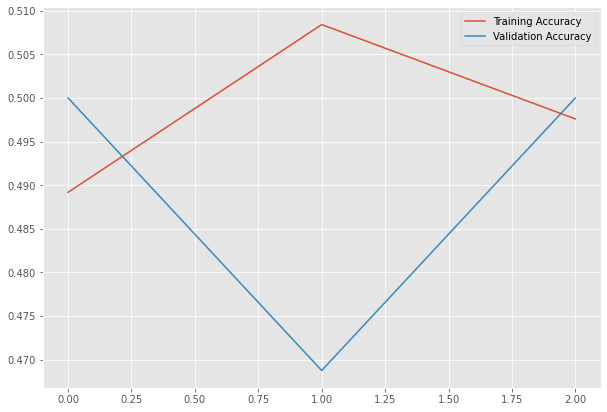

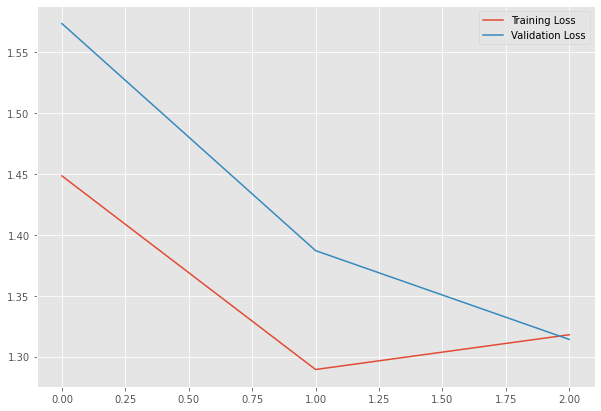

In [94]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.figure(figsize=(10,7))
plt.plot(history['train_accuracy'],label='Training Accuracy')
plt.plot(history['val_accuracy'],label='Validation Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(10,7))
plt.plot(history['train_loss'],label='Training Loss')
plt.plot(history['val_loss'],label='Validation Loss')
plt.legend()
plt.show()